# FML Capstone - Classification
Erin Choi

In [107]:
import random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP, plot

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from scikitplot.metrics import plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
# set seed
random.seed(11884031)
np.random.seed(11884031)

# Data Preprocessing

In [14]:
# import the data
data = pd.read_csv('musicData.csv', encoding='utf-8')
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [15]:
# drop string & uninformative features:
# instance_id, artist_name, track_name, obtained_date
data.drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date'],
          inplace=True)
data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic


## Handle Missing Values

In [16]:
# drop rows with nans
data[data.isnull().any(axis=1)]

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data.dropna(inplace=True)
data.shape

(50000, 14)

In [18]:
# drop any rows with strange values
data.head(10)
# duration of -1 & tempo of ? observed

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,0.323,Electronic
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.614,Electronic
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,0.230,Electronic
7,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,0.761,Electronic
8,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,0.273,Electronic
9,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,0.203,Electronic


In [19]:
len(data[data['duration_ms']==-1]), len(data[data['tempo']=='?'])

(4939, 4980)

The proportion of songs with missing values may be too large to impute with a mean or median without significantly affecting classification results - so I drop them.

In [20]:
# remove rows with strange missing values
data_new = data[(data['duration_ms'] != -1) & 
                (data['tempo'] != '?')]
data_new.shape

(40560, 14)

In [21]:
# check types and convert as necessary
data_new.dtypes
# tempo is object because of the previously contained ? values

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object

In [22]:
data_new['tempo'] = data_new['tempo'].astype('float64')
data_new.dtypes

/var/folders/y8/06h7mcw93vl31wb8t9y5l8wc0000gn/T/ipykernel_91780/134623865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['tempo'] = data_new['tempo'].astype('float64')


popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo               float64
valence             float64
music_genre          object
dtype: object

## Dummy Encoding

In [23]:
# check key, mode, genre values
data_new['key'].value_counts() # 12 values

G     4630
C     4467
C#    4445
D     4244
A     3947
F     3486
B     3074
E     3030
G#    2729
A#    2721
F#    2484
D#    1303
Name: key, dtype: int64

In [10]:
data_new['mode'].value_counts() # 2 values

Major    25959
Minor    14601
Name: mode, dtype: int64

In [24]:
data_new['music_genre'].value_counts() # 10 values, as expected

Rock           4099
Hip-Hop        4077
Anime          4064
Jazz           4064
Alternative    4051
Country        4049
Blues          4046
Rap            4042
Classical      4036
Electronic     4032
Name: music_genre, dtype: int64

In [25]:
# the order of the genres turned into categories 0-9
data.music_genre.unique()
# so electronic = 0, anime = 1, etc.

array(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop'], dtype=object)

In [26]:
# turn genre (target) into numerical categories 0-9
data_new['music_genre'] = pd.factorize(data_new['music_genre'])[0]
data_new.head()

/var/folders/y8/06h7mcw93vl31wb8t9y5l8wc0000gn/T/ipykernel_91780/4002897084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['music_genre'] = pd.factorize(data_new['music_genre'])[0]


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.124,-7.043,Minor,0.0300,115.002,0.531,0
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.534,-4.617,Major,0.0345,127.994,0.333,0
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.157,-4.498,Major,0.2390,128.014,0.270,0
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.157,-6.266,Major,0.0413,145.036,0.323,0
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.106,-4.294,Major,0.3510,149.995,0.230,0


In [27]:
# encode key & mode into dummies -
# they are categorical & non-ordinal features
data_encoded = pd.get_dummies(data_new, columns=['key', 'mode'])
data_encoded.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor
1,31.0,0.01270,0.622,218293.0,0.890,0.950000,0.124,-7.043,0.0300,115.002,...,0,1,0,0,0,0,0,0,0,1
2,28.0,0.00306,0.620,215613.0,0.755,0.011800,0.534,-4.617,0.0345,127.994,...,0,0,0,0,0,0,0,1,1,0
3,34.0,0.02540,0.774,166875.0,0.700,0.002530,0.157,-4.498,0.2390,128.014,...,1,0,0,0,0,0,0,0,1,0
4,32.0,0.00465,0.638,222369.0,0.587,0.909000,0.157,-6.266,0.0413,145.036,...,0,0,0,0,0,1,0,0,1,0
6,46.0,0.02890,0.572,214408.0,0.803,0.000008,0.106,-4.294,0.3510,149.995,...,0,0,0,0,0,0,0,0,1,0


# Train/Test Split

In [228]:
# find the necessary test set size - 1/10 of the total data
data_encoded.shape[0]/10

4056.0

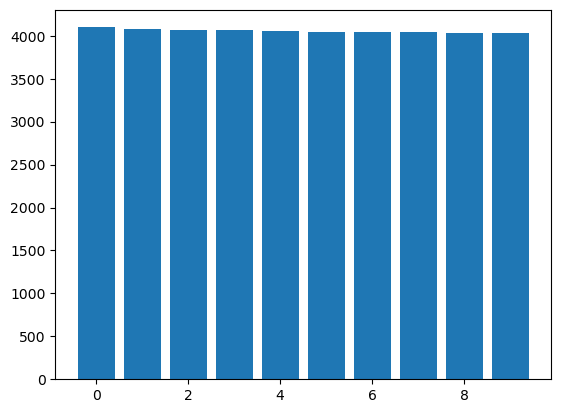

In [229]:
plt.bar(np.arange(10), data_encoded['music_genre'].value_counts())
plt.show()

In [29]:
dataX = data_encoded.copy().drop(columns=['music_genre'])
dataY = pd.DataFrame(data_encoded.copy()['music_genre'])

In [30]:
# split data into train/test sets, using StratifiedShuffleSplit
# to make sure training and test sets have the same proportion of genre classes
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state=11884031)
for train_index, test_index in split.split(dataX, dataY):
    xTrain = dataX.iloc[train_index]
    yTrain = dataY.iloc[train_index]
    xTest = dataX.iloc[test_index]
    yTest = dataY.iloc[test_index]
    
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(36504, 25) (4056, 25) (36504, 1) (4056, 1)


In [232]:
yTrain['music_genre'].value_counts()

7    3689
9    3669
1    3658
2    3658
3    3646
4    3644
6    3641
5    3638
8    3632
0    3629
Name: music_genre, dtype: int64

In [197]:
3689/36504, 3629/36504

(0.10105741836511067, 0.09941376287530133)

In [233]:
yTest['music_genre'].value_counts()

7    410
9    408
2    406
1    406
6    405
4    405
3    405
8    404
5    404
0    403
Name: music_genre, dtype: int64

In [198]:
410/4056, 403/4056

(0.10108481262327416, 0.09935897435897435)

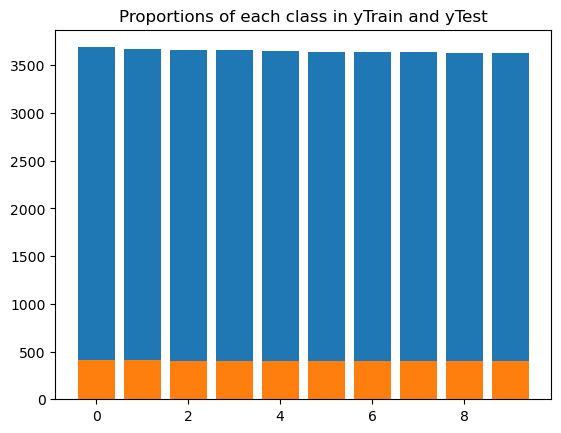

In [234]:
# proportions of each class in yTrain and yTest
plt.title("Proportions of each class in yTrain and yTest")
plt.bar(np.arange(10), yTrain['music_genre'].value_counts())
plt.bar(np.arange(10), yTest['music_genre'].value_counts())
plt.show()

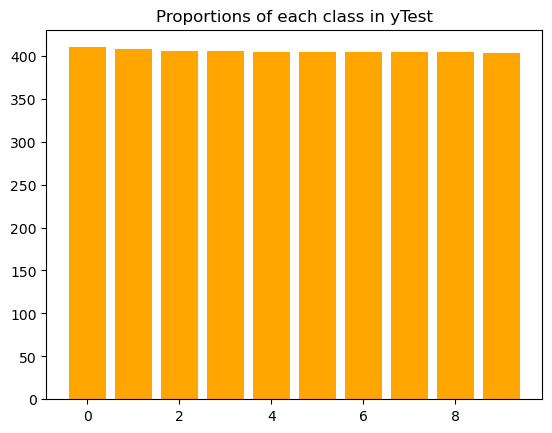

In [235]:
# closer look: proportions of each class in yTest
plt.title("Proportions of each class in yTest")
plt.bar(np.arange(10), yTest['music_genre'].value_counts(), color='orange')
plt.show()
# looks the same as blue bars above

# Scale Features
Done after train/test split to avoid data leakage

In [31]:
# check which columns to standardize
xTrain.select_dtypes(include='float64').describe()

# popularity, duration_ms, loudness, tempo are outside of 0-1 range
# while all other features are between 0-1, including the dummies encoded above

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,36504.000000,36504.000000,36504.000000,3.650400e+04,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000
mean,44.251452,0.305583,0.558338,2.454220e+05,0.600946,0.181623,0.193971,-9.112141,0.093593,119.956526,0.457433
std,15.509150,0.340799,0.178682,1.093732e+05,0.264656,0.325696,0.161751,6.137928,0.101127,30.667839,0.247068
min,0.000000,0.000001,0.060000,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,34.000000,0.020000,0.443000,1.906168e+05,0.434000,0.000000,0.097000,-10.841250,0.036100,94.964750,0.259000
50%,45.000000,0.144000,0.568000,2.276425e+05,0.645000,0.000162,0.126000,-7.270000,0.048800,119.808000,0.450000
75%,56.000000,0.547000,0.687000,2.756432e+05,0.817000,0.152000,0.244000,-5.168750,0.098800,140.486000,0.649000
max,99.000000,0.996000,0.986000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [32]:
float_cols = xTrain.select_dtypes(include='float64').columns
scale_cols = ['popularity', 'duration_ms', 'loudness', 'tempo']

In [33]:
# scale the columns identified above
scaler = MinMaxScaler().fit(xTrain[scale_cols])
xTrain[scale_cols] = scaler.transform(xTrain[scale_cols])
xTest[scale_cols] = scaler.transform(xTest[scale_cols])

/var/folders/y8/06h7mcw93vl31wb8t9y5l8wc0000gn/T/ipykernel_91780/2838647055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xTrain[scale_cols] = scaler.transform(xTrain[scale_cols])
/var/folders/y8/06h7mcw93vl31wb8t9y5l8wc0000gn/T/ipykernel_91780/2838647055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xTest[scale_cols] = scaler.transform(xTest[scale_cols])


In [34]:
xTrain.select_dtypes(include='float64').describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000,36504.000000
mean,0.446984,0.305583,0.558338,0.051291,0.600946,0.181623,0.193971,0.746877,0.093593,0.460442,0.457433
std,0.156658,0.340799,0.178682,0.024400,0.264656,0.325696,0.161751,0.120849,0.101127,0.164944,0.247068
min,0.000000,0.000001,0.060000,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,0.343434,0.020000,0.443000,0.039065,0.434000,0.000000,0.097000,0.712832,0.036100,0.326026,0.259000
50%,0.454545,0.144000,0.568000,0.047325,0.645000,0.000162,0.126000,0.783146,0.048800,0.459643,0.450000
75%,0.565657,0.547000,0.687000,0.058033,0.817000,0.152000,0.244000,0.824518,0.098800,0.570858,0.649000
max,1.000000,0.996000,0.986000,1.000000,0.999000,0.996000,1.000000,1.000000,0.942000,1.000000,0.992000


In [35]:
xTest.select_dtypes(include='float64').describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000,4056.000000
mean,0.449532,0.309491,0.559144,0.051442,0.594784,0.181421,0.192457,0.744075,0.095047,0.456032,0.452308
std,0.160305,0.343893,0.178402,0.026024,0.263064,0.325874,0.159255,0.124095,0.104820,0.164123,0.245786
min,0.000000,0.000000,0.059600,0.000180,0.001060,0.000000,0.022100,0.001201,0.022700,0.071839,0.000000
25%,0.343434,0.019775,0.440000,0.038665,0.431000,0.000000,0.096900,0.712690,0.036000,0.320648,0.253000
50%,0.454545,0.146000,0.572000,0.047104,0.632000,0.000115,0.126000,0.781699,0.049800,0.455144,0.441000
75%,0.565657,0.566750,0.688000,0.058187,0.809000,0.150250,0.238000,0.823203,0.098950,0.568432,0.642000
max,0.969697,0.996000,0.980000,0.613371,0.998000,0.992000,0.990000,0.946426,0.920000,0.987366,0.987000


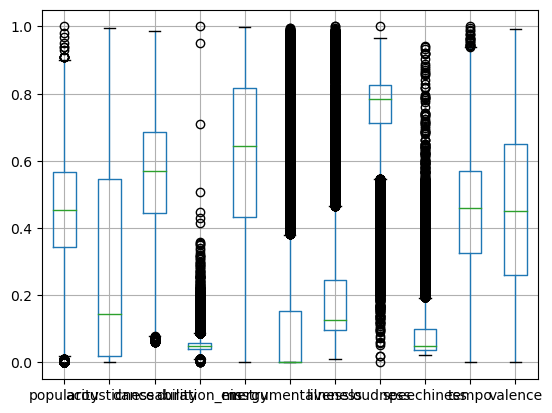

In [36]:
xTrain.select_dtypes(include='float64').boxplot()
plt.show()

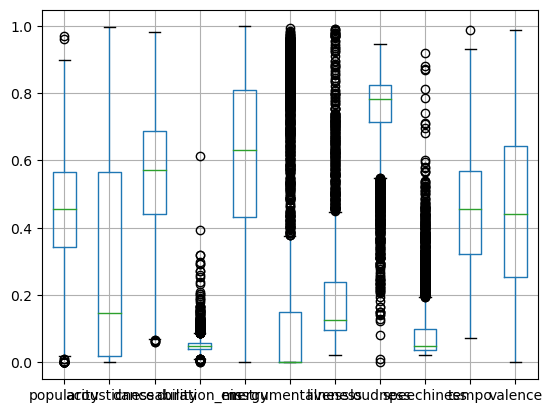

In [199]:
xTest.select_dtypes(include='float64').boxplot()
plt.show()

# Dimensionality Reduction

## PCA

In [37]:
# pca
pca = PCA(whiten=True, random_state=11880431).fit(xTrain) 
xTrain_pca = pca.transform(xTrain)

In [38]:
eigvals = pca.explained_variance_
len(eigvals)

25

In [39]:
eigvals

array([4.69554552e-01, 2.35659047e-01, 1.12257222e-01, 1.08713122e-01,
       1.06273544e-01, 9.86141929e-02, 8.84828370e-02, 7.93783279e-02,
       7.57798300e-02, 7.48535965e-02, 7.02205009e-02, 6.63024535e-02,
       6.25747703e-02, 5.43296897e-02, 3.42636857e-02, 3.24448625e-02,
       2.55345842e-02, 2.15164652e-02, 1.66923353e-02, 1.45450309e-02,
       8.30206815e-03, 2.80891801e-03, 5.54587216e-04, 7.33651279e-33,
       1.28910143e-33])

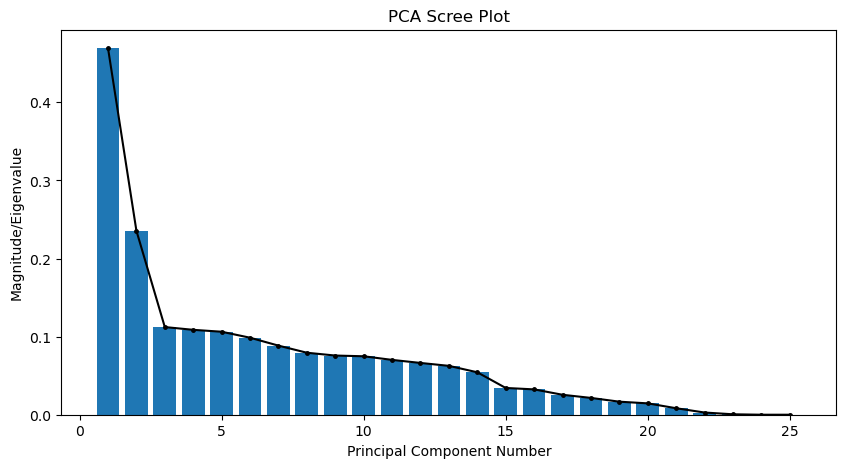

In [40]:
# scree plot
plt.figure(figsize=(10, 5))
plt.bar(range(1,26), eigvals)
plt.plot(range(1,26), eigvals, color='black', marker='.', markersize=5)
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component Number')
plt.ylabel('Magnitude/Eigenvalue')
plt.show()

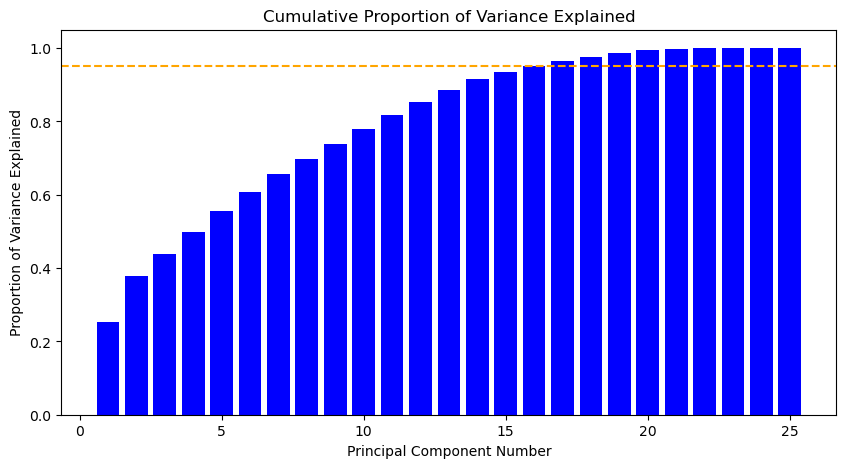

In [41]:
# plot cumulative proportion of explained variance
plt.figure(figsize=(10, 5))
for i in np.arange(1,26):
    plt.bar(i, sum(pca.explained_variance_ratio_[:i]), color='b')
plt.axhline(0.95, color='orange', linestyle='--')
plt.title('Cumulative Proportion of Variance Explained')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [42]:
# variance explained by pc1 and pc2 projection
print("Variance explained by PC1:", pca.explained_variance_ratio_[0])
print("Variance explained by PC2:", pca.explained_variance_ratio_[1])
print("Variance explained by first 16 PCs:", pca.explained_variance_ratio_[:16].sum())

Variance explained by PC1: 0.2524953517525079
Variance explained by PC2: 0.1267218341625276
Variance explained by first 16 PCs: 0.9516287000007064


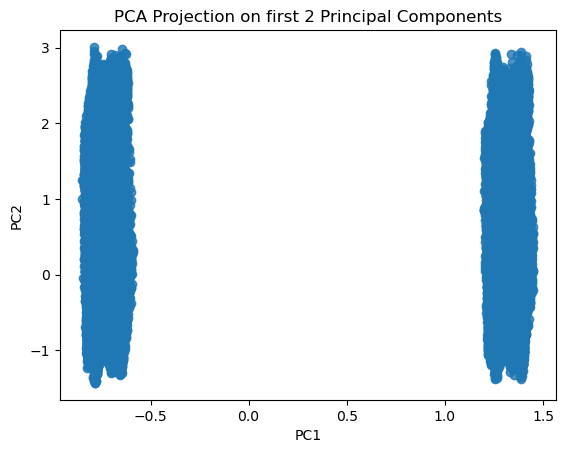

In [43]:
# plot 2D
plt.scatter(xTrain_pca[:, 0], xTrain_pca[:, 1], alpha=0.8)
# plt.scatter(xTrain_pca[0], xTrain_pca[1], alpha=0.8)
plt.title("PCA Projection on first 2 Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

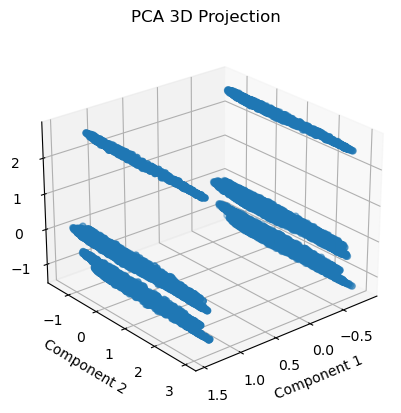

In [44]:
# PCA 3D projection
ax = plt.axes(projection='3d')
ax.scatter3D(xTrain_pca[:, 0], xTrain_pca[:, 1], xTrain_pca[:, 2])
plt.title("PCA 3D Projection")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.view_init(25, 50)
plt.show()

In [45]:
xTest_pca = pca.transform(xTest)

In [46]:
xTrain_pca = pd.DataFrame(xTrain_pca[:,:16])
xTest_pca = pd.DataFrame(xTest_pca[:,:16])
xTrain_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.694344,0.358886,-0.029554,-0.093348,0.113691,0.235769,0.610232,0.966011,-1.476292,-1.080452,1.976931,-2.846770,-0.600975,1.113794,0.096939,1.173763
1,1.380332,-1.038323,0.029651,-0.215156,0.135030,-0.184834,0.065828,1.350318,-0.827278,2.682806,-1.370129,-0.353333,-0.409719,0.116329,0.448955,1.886230
2,-0.738949,-0.183937,-0.041034,-0.037184,0.074126,0.188374,0.365775,0.440624,-0.397248,-0.261517,-0.029191,-0.130453,0.231942,0.111571,5.209987,-1.706799
3,1.343880,-0.482134,0.001221,-0.168212,0.077951,-0.072211,0.166273,0.338650,-0.730553,-0.359687,0.724234,0.529571,3.628426,0.841202,-0.316984,-0.114711
4,-0.793161,-0.578222,2.554096,-0.181203,-0.555308,-0.398414,-0.437967,-0.399767,0.056986,0.074965,-0.104066,0.062560,-0.073213,-0.888305,-0.510363,-1.371729


# Clustering

## kMeans on PCA

In [504]:
# keep track of silhouettes
silhouettes = np.zeros(51)

# kmeans for 2-49 clusters
for k in range(2, 50):
    kmeans = KMeans(k, n_init='auto', random_state=11884031)
    labels = kmeans.fit_predict(xTrain_pca)
    silhouettes[k-1] = silhouette_score(xTrain_pca, labels)

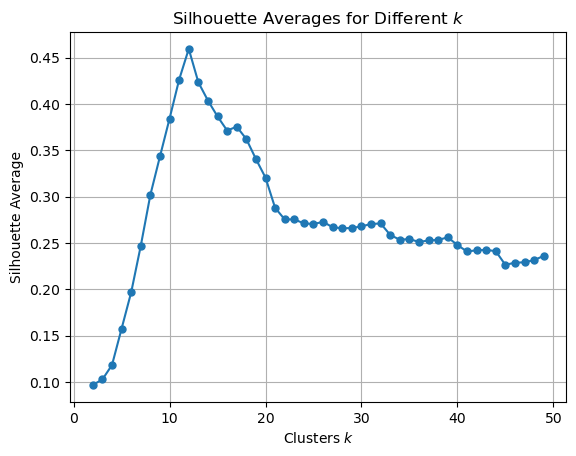

In [509]:
# plot silhouette scores
plt.plot(np.arange(2, 50, 1), silhouettes[1:49], marker='o', markersize=5)
plt.xlabel('Clusters $k$')
plt.ylabel('Silhouette Average')
plt.title('Silhouette Averages for Different $k$')
plt.grid()
plt.show()

In [52]:
yTrain_reset = yTrain.reset_index(drop=True)
yTest_reset = yTest.reset_index(drop=True)
yTrain_reset.head()

,music_genre
0,4
1,1
2,4
3,4
4,0


In [53]:
# kmeans using 12 clusters
kmeans = KMeans(12, n_init='auto', random_state=11884031)
# predict labels
km_label = kmeans.fit_predict(xTrain_pca)
unique_km_labels = np.unique(km_label)

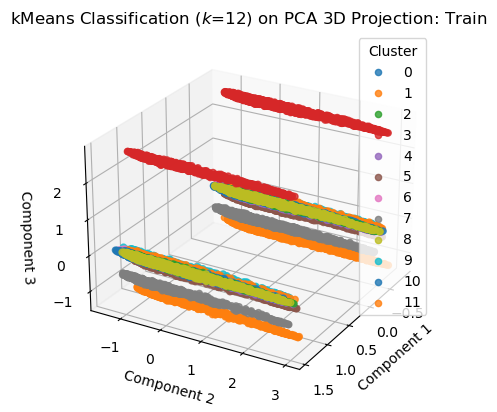

In [283]:
# plot cluster in diff colors on PCA 3D projection
ax = plt.axes(projection='3d')
for i in unique_km_labels:
    ax.scatter3D(xTrain_pca[km_label == i][0], 
                 xTrain_pca[km_label == i][1],
                 xTrain_pca[km_label == i][2],
                label=i, alpha=0.8)
plt.title("kMeans Classification ($k$=12) on PCA 3D Projection: Train")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.view_init(25, 30)
plt.legend(title="Cluster")
plt.show()

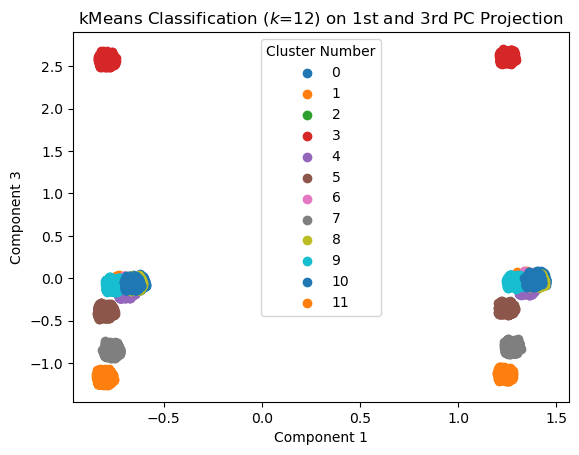

In [280]:
# 1st and 3rd PCs
for i in unique_km_labels:
    plt.scatter(xTrain_pca[km_label == i][0],  
                xTrain_pca[km_label == i][2], 
                label=i)
plt.title("kMeans Classification ($k$=12) on 1st and 3rd PC Projection")
plt.xlabel("Component 1")
plt.ylabel("Component 3")
plt.legend(title="Cluster Number", loc="upper center")
plt.show()

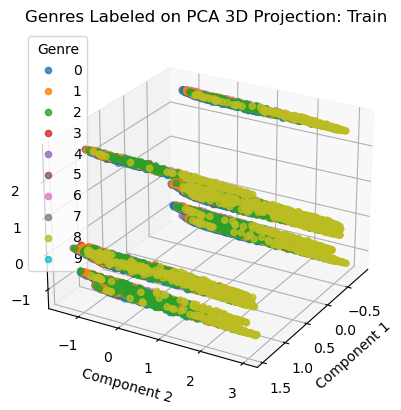

In [286]:
# plot genres in diff colors on PCA 3D projection
ax = plt.axes(projection='3d')
for i in np.unique(yTrain):
    ax.scatter3D(xTrain_pca[yTrain_reset.music_genre == i][0], 
                 xTrain_pca[yTrain_reset.music_genre == i][1],
                 xTrain_pca[yTrain_reset.music_genre == i][2],
                label=i, alpha=0.8)
plt.title("Genres Labeled on PCA 3D Projection: Train")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.view_init(25,30)
plt.legend(title="Genre")
plt.show()

In [215]:
# see what features are most important for PC1-3
pca_components = pd.DataFrame(pca.components_, columns = xTrain.columns)
pca_components[:3]

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor
0,0.002770,-0.012299,0.012145,0.000668,0.006006,0.036351,-0.004002,0.000757,0.011169,-0.006359,...,-0.033979,-0.054879,-0.000287,0.049826,0.033542,0.026006,-0.050178,-0.026387,-0.699295,0.699295
1,-0.128738,0.621636,-0.174984,0.008295,-0.470262,0.461001,-0.049860,-0.211581,-0.050571,-0.091467,...,-0.076973,0.009060,0.030074,0.005966,0.035621,-0.027586,0.015695,-0.012456,0.003558,-0.003558
2,-0.015485,-0.006873,-0.009253,-0.000158,0.015592,0.002169,0.012797,0.001282,-0.010460,-0.003735,...,-0.270995,-0.118166,-0.004171,-0.009201,-0.019763,-0.005489,0.874144,-0.013658,-0.006628,0.006628


In [216]:
# PC1 components
pc1_comp = pca_components.iloc[0].sort_values(key=abs, ascending=False)
pc1_comp

mode_Minor          0.699295
mode_Major         -0.699295
key_C              -0.057010
key_B               0.056294
key_D              -0.054879
key_G              -0.050178
key_E               0.049826
key_A#              0.040304
instrumentalness    0.036351
key_C#             -0.033979
key_F               0.033542
key_G#             -0.026387
key_F#              0.026006
key_A               0.016748
acousticness       -0.012299
danceability        0.012145
valence            -0.011806
speechiness         0.011169
tempo              -0.006359
energy              0.006006
liveness           -0.004002
popularity          0.002770
loudness            0.000757
duration_ms         0.000668
key_D#             -0.000287
Name: 0, dtype: float64

In [217]:
# PC2 components
pc2_comp = pca_components.iloc[1].sort_values(key=abs, ascending=False)
pc2_comp

acousticness        0.621636
energy             -0.470262
instrumentalness    0.461001
valence            -0.247800
loudness           -0.211581
danceability       -0.174984
popularity         -0.128738
tempo              -0.091467
key_C#             -0.076973
speechiness        -0.050571
liveness           -0.049860
key_C               0.043831
key_B              -0.039896
key_F               0.035621
key_D#              0.030074
key_F#             -0.027586
key_G               0.015695
key_G#             -0.012456
key_A#              0.009477
key_D               0.009060
duration_ms         0.008295
key_A               0.007187
key_E               0.005966
mode_Minor         -0.003558
mode_Major          0.003558
Name: 1, dtype: float64

In [218]:
# PC3 components
pc3_comp = pca_components.iloc[2].sort_values(key=abs, ascending=False)
pc3_comp

key_G               0.874144
key_C              -0.379143
key_C#             -0.270995
key_D              -0.118166
key_A              -0.039363
valence             0.036921
key_F              -0.019763
energy              0.015592
popularity         -0.015485
key_G#             -0.013658
liveness            0.012797
speechiness        -0.010460
danceability       -0.009253
key_E              -0.009201
key_A#             -0.007732
acousticness       -0.006873
mode_Minor          0.006628
mode_Major         -0.006628
key_B              -0.006462
key_F#             -0.005489
key_D#             -0.004171
tempo              -0.003735
instrumentalness    0.002169
loudness            0.001282
duration_ms        -0.000158
Name: 2, dtype: float64

In [234]:
print("Most important features in PC1:", pc1_comp[:2].index.values)
print("Most important features in PC2:", pc2_comp[:3].index.values)
print("Most important features in PC3:", pc3_comp[:5].index.values)

Most important features in PC1: ['mode_Minor' 'mode_Major']
Most important features in PC2: ['acousticness' 'energy' 'instrumentalness']
Most important features in PC3: ['key_G' 'key_C' 'key_C#' 'key_D' 'key_A']


In [223]:
xTrain_reset = xTrain.reset_index(drop=True)

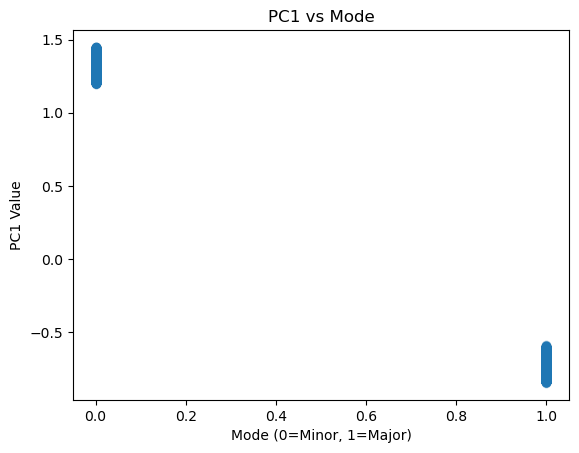

In [233]:
# PC1 vs mode
plt.scatter(xTrain_reset['mode_Major'], xTrain_pca[0], alpha=0.2)
plt.title("PC1 vs Mode")
plt.xlabel("Mode (0=Minor, 1=Major)")
plt.ylabel("PC1 Value")
plt.show()

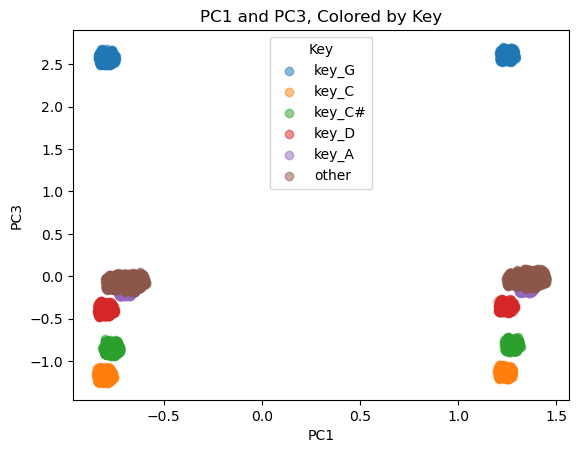

In [259]:
# color projection by key
impt_keys = ['key_G', 'key_C', 'key_C#', 'key_D', 'key_A', 'other']
other_key_ix = xTrain_reset[(xTrain_reset['key_G']==0) &
                            (xTrain_reset['key_C']==0) &
                            (xTrain_reset['key_C#']==0) &
                            (xTrain_reset['key_D']==0) &
                            (xTrain_reset['key_A']==0)].index
for k in impt_keys:
    if k=='other':
        plt.scatter(xTrain_pca[0][other_key_ix],
                    xTrain_pca[2][other_key_ix], 
                    label=k, alpha=0.5)
    else:
        plt.scatter(xTrain_pca[0][xTrain_reset[xTrain_reset[k]==1].index], 
                    xTrain_pca[2][xTrain_reset[xTrain_reset[k]==1].index], 
                    label=k, alpha=0.5)
plt.title("PC1 and PC3, Colored by Key")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.legend(title="Key", loc="upper center")
plt.show()

In [58]:
km_label_test = kmeans.predict(xTest_pca)

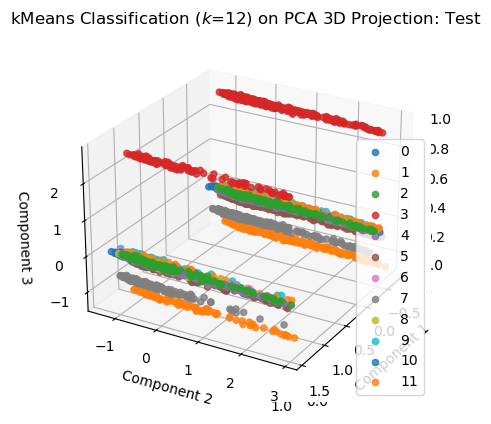

In [59]:
# plot cluster in diff colors on PCA 3D projection
ax = plt.axes(projection='3d')
for i in np.unique(km_label_test):
    ax.scatter3D(xTest_pca[km_label_test == i][0], 
                 xTest_pca[km_label_test == i][1],
                 xTest_pca[km_label_test == i][2],
                label=i, alpha=0.8)
plt.title("kMeans Classification ($k$=12) on PCA 3D Projection: Test")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.view_init(25, 30)
plt.legend()
plt.show()

In [60]:
# add cluster numbers to pca projection data
xTrain_pca_cluster = xTrain_pca.copy()
xTrain_pca_cluster['cluster'] = km_label
xTest_pca_cluster = xTest_pca.copy()
xTest_pca_cluster['cluster'] = km_label_test

# add clusters numbers to orig data
xTrain_orig_pca_cluster = xTrain.copy()
xTrain_orig_pca_cluster['cluster'] = km_label
xTest_orig_pca_cluster = xTest.copy()
xTest_orig_pca_cluster['cluster'] = km_label_test

In [61]:
xTrain_pca_cluster.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cluster
0,-0.694344,0.358886,-0.029554,-0.093348,0.113691,0.235769,0.610232,0.966011,-1.476292,-1.080452,1.976931,-2.846770,-0.600975,1.113794,0.096939,1.173763,10
1,1.380332,-1.038323,0.029651,-0.215156,0.135030,-0.184834,0.065828,1.350318,-0.827278,2.682806,-1.370129,-0.353333,-0.409719,0.116329,0.448955,1.886230,8
2,-0.738949,-0.183937,-0.041034,-0.037184,0.074126,0.188374,0.365775,0.440624,-0.397248,-0.261517,-0.029191,-0.130453,0.231942,0.111571,5.209987,-1.706799,1
3,1.343880,-0.482134,0.001221,-0.168212,0.077951,-0.072211,0.166273,0.338650,-0.730553,-0.359687,0.724234,0.529571,3.628426,0.841202,-0.316984,-0.114711,6
4,-0.793161,-0.578222,2.554096,-0.181203,-0.555308,-0.398414,-0.437967,-0.399767,0.056986,0.074965,-0.104066,0.062560,-0.073213,-0.888305,-0.510363,-1.371729,3


In [62]:
xTrain_orig_pca_cluster.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor,cluster
22530,0.414141,0.7520,0.491,0.036096,0.512,0.000007,0.0925,0.746938,0.0352,0.496996,...,0,0,0,0,0,0,0,1,0,10
7400,0.292929,0.0038,0.491,0.047554,0.966,0.000000,0.4520,0.872455,0.1600,0.649043,...,0,0,1,0,0,0,0,0,1,8
24611,0.464646,0.3000,0.545,0.040013,0.597,0.000000,0.0783,0.813113,0.0336,0.534242,...,0,1,0,0,0,0,0,1,0,1
20587,0.636364,0.4030,0.628,0.044618,0.834,0.000000,0.0510,0.801437,0.0497,0.341625,...,0,0,0,0,1,0,0,0,1,6
4669,0.313131,0.0119,0.868,0.054498,0.702,0.017200,0.0507,0.827289,0.0539,0.471422,...,0,0,0,0,0,1,0,1,0,3


In [63]:
# turn column names into strings
xTrain_pca_cluster.columns = xTrain_pca_cluster.columns.astype(str)
xTest_pca_cluster.columns = xTest_pca_cluster.columns.astype(str)

In [64]:
# dummy encode cluster feature in pcs data
xTrain_pca_cluster_enc = pd.get_dummies(xTrain_pca_cluster, columns=['cluster'])
xTest_pca_cluster_enc = pd.get_dummies(xTest_pca_cluster, columns=['cluster'])

In [65]:
# dummy encode cluster feature in original data
xTrain_orig_pca_cluster_enc = pd.get_dummies(xTrain_orig_pca_cluster, columns=['cluster'])
xTest_orig_pca_cluster_enc = pd.get_dummies(xTest_orig_pca_cluster, columns=['cluster'])

In [453]:
# use dbscan
db_pca = DBSCAN(eps=10, min_samples=10)
db_model_pca = db.fit(xTrain_pca)

# get labels
db_label_pca = db_model_pca.labels_
unique_db_labels_pca = np.unique(db_label_pca)
unique_db_labels_pca

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [440]:
xTrain_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.694344,0.358886,-0.029554,-0.093348,0.113691,0.235769,0.610232,0.966011,-1.476292,-1.080452,1.976931,-2.846770,-0.600975,1.113794,0.096939,1.173763
1,1.380332,-1.038323,0.029651,-0.215156,0.135030,-0.184834,0.065828,1.350318,-0.827278,2.682806,-1.370129,-0.353333,-0.409719,0.116329,0.448955,1.886230
2,-0.738949,-0.183937,-0.041034,-0.037184,0.074126,0.188374,0.365775,0.440624,-0.397248,-0.261517,-0.029191,-0.130453,0.231942,0.111571,5.209987,-1.706799
3,1.343880,-0.482134,0.001221,-0.168212,0.077951,-0.072211,0.166273,0.338650,-0.730553,-0.359687,0.724234,0.529571,3.628426,0.841202,-0.316984,-0.114711
4,-0.793161,-0.578222,2.554096,-0.181203,-0.555308,-0.398414,-0.437967,-0.399767,0.056986,0.074965,-0.104066,0.062560,-0.073213,-0.888305,-0.510363,-1.371729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36499,-0.746832,0.517306,-0.816116,2.292618,-1.411283,-0.415831,-0.579634,-0.527773,0.990988,0.466428,0.299229,-0.249919,-0.194649,2.768083,-0.287290,-0.577297
36500,-0.810333,-0.740328,-1.148775,-2.141967,-1.039729,-0.607381,-0.607646,-0.590336,0.440789,0.418543,-0.046736,0.015893,-0.115057,-0.859399,0.197653,0.557361
36501,1.394284,-0.594194,-0.031047,-0.140468,0.097900,-0.232741,0.036900,1.517149,1.870332,-1.697328,-1.456281,-0.090806,-0.176903,-1.579546,-0.075039,0.246289
36502,-0.803663,-0.366146,2.550568,-0.199532,-0.544144,-0.371884,-0.397439,-0.355344,-0.240596,-0.119555,-0.226037,0.090218,-0.056915,-0.972706,-0.273852,-0.528014


In [450]:
xTrain_pca[db_label_pca == 0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.694344,0.358886,-0.029554,-0.093348,0.113691,0.235769,0.610232,0.966011,-1.476292,-1.080452,1.976931,-2.846770,-0.600975,1.113794,0.096939,1.173763
6,-0.667381,-0.628309,-0.038000,-0.044529,0.121869,0.077225,0.329598,0.824923,-0.039594,0.054982,2.280755,-2.789438,-0.559364,-1.424253,0.082991,0.847631
75,-0.674324,-0.565126,-0.021986,-0.088708,0.122162,0.127406,0.431991,0.837476,-0.447998,-0.283501,2.235696,-2.856759,-0.610141,-0.177685,-0.022371,0.640987
97,-0.662199,-0.311226,-0.117257,0.056977,0.034203,0.085066,0.400397,0.961144,-0.660607,-0.468777,2.182080,-2.653006,-0.538613,-1.598746,-0.871647,-1.706225
149,-0.654951,2.294658,-0.123715,0.310307,-0.000343,0.065607,0.228524,1.000559,0.077648,-0.091989,2.300392,-2.705246,-0.472484,-0.909433,-0.128132,0.913572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36389,-0.683990,1.031222,-0.128239,0.100960,0.033689,0.158716,0.543681,1.162138,-1.751676,-1.281216,1.765647,-2.614449,-0.454436,-1.554114,-0.563601,0.172028
36395,-0.694965,1.305284,-0.081610,0.043569,0.070137,0.215020,0.569929,1.097539,-1.708856,-1.256539,1.782319,-2.708114,-0.483913,-0.443348,0.071220,1.719025
36455,-0.681348,0.372994,-0.092635,0.019856,0.071999,0.157143,0.506623,1.041669,-1.282740,-0.905856,1.954714,-2.679705,-0.506817,-0.982521,-0.424186,-0.188729
36460,-0.680356,0.222328,-0.082876,0.000129,0.079742,0.145914,0.482388,0.992146,-1.064943,-0.742285,2.006330,-2.712172,-0.529291,-0.985062,-0.189408,0.476185


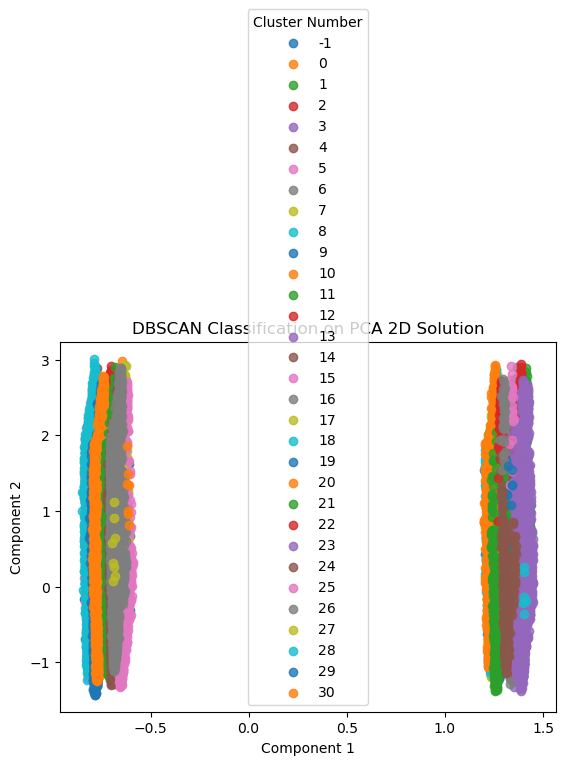

In [451]:
# plot clusters in different colors

for i in unique_db_labels_pca:
    plt.scatter(xTrain_pca[db_label_pca == i][0],  
                xTrain_pca[db_label_pca == i][1], 
                label=i, alpha=0.8)
            
plt.title("DBSCAN Classification on PCA 2D Solution")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Cluster Number")
plt.show()

# Classification Model & Evaluation

## RF

In [74]:
# orig data without cluster
rf = RandomForestClassifier(n_estimators=248, 
                            criterion='gini',
                            min_samples_split=25,
                            n_jobs=-1, random_state=11884031).fit(xTrain, yTrain.values.ravel())
yPred_rf = rf.predict(xTest)
yProb_rf = rf.predict_proba(xTest)

# evaluate on test set
print("RF")

auroc_rf = roc_auc_score(yTest, yProb_rf, multi_class='ovr')
print("AUROC = {:0.5f}".format(auroc_rf))

acc_rf = accuracy_score(yTest, yPred_rf)
print("Accuracy = {:0.2f}%".format(acc_rf * 100))

RF
AUROC = 0.92561
Accuracy = 56.02%


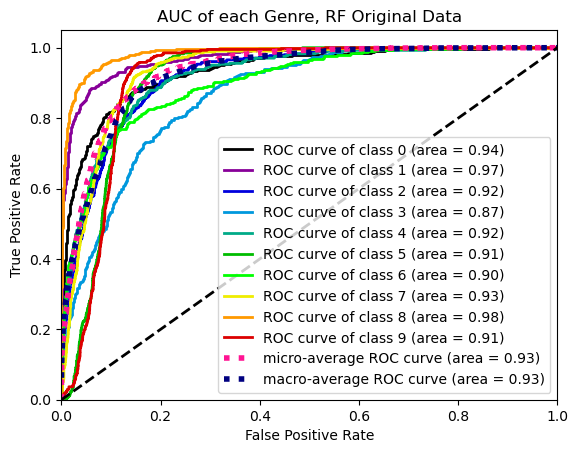

In [288]:
plot_roc(yTest, yProb_rf, title="AUC of each Genre, RF Original Data")
plt.show()

In [91]:
# orig data with pca kmeans cluster
rf2 = RandomForestClassifier(n_estimators=245, 
                            criterion='gini',
                            min_samples_split=30,
                            min_samples_leaf=4,
                            n_jobs=-1, random_state=11884031).fit(xTrain_orig_pca_cluster_enc, yTrain.values.ravel())
yPred_rf2 = rf2.predict(xTest_orig_pca_cluster_enc)
yProb_rf2 = rf2.predict_proba(xTest_orig_pca_cluster_enc)

# evaluate on test set
print("RF")

auroc_rf2 = roc_auc_score(yTest, yProb_rf2, multi_class='ovr')
print("AUROC = {:0.5f}".format(auroc_rf2))

acc_rf2 = accuracy_score(yTest, yPred_rf2)
print("Accuracy = {:0.2f}%".format(acc_rf2 * 100))

RF
AUROC = 0.92516
Accuracy = 56.19%


In [106]:
# pca projection (16 PC) with kmeans cluster
rf3 = RandomForestClassifier(n_estimators=291, 
                            criterion='gini',
                            min_samples_split=34,
                            n_jobs=-1, random_state=11884031).fit(xTrain_pca_cluster_enc, yTrain.values.ravel())
yPred_rf3 = rf3.predict(xTest_pca_cluster_enc)
yProb_rf3 = rf3.predict_proba(xTest_pca_cluster_enc)

# evaluate on test set
print("RF")

auroc_rf3 = roc_auc_score(yTest, yProb_rf3, multi_class='ovr')
print("AUROC = {:0.5f}".format(auroc_rf3))

acc_rf3 = accuracy_score(yTest, yPred_rf3)
print("Accuracy = {:0.2f}%".format(acc_rf3 * 100))

RF
AUROC = 0.83753
Accuracy = 38.04%


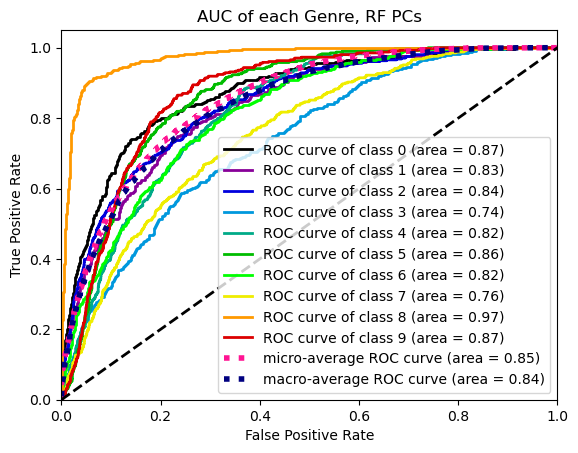

In [289]:
plot_roc(yTest, yProb_rf3, title="AUC of each Genre, RF PCs")
plt.show()

### Feature Importance

In [272]:
# RF1 feature importance
rf_feat = pd.DataFrame(xTrain.columns.values, columns=['Feature'])
rf_feat['Importance'] = rf.feature_importances_
rf_feat.sort_values(by='Importance', key=abs, ascending=False)[:10]

,Feature,Importance
0,popularity,0.240700
7,loudness,0.096594
8,speechiness,0.096250
1,acousticness,0.092851
5,instrumentalness,0.092786
2,danceability,0.091002
4,energy,0.075200
10,valence,0.055980
3,duration_ms,0.051266
9,tempo,0.035963


In [275]:
# RF2 feature importance
rf2_feat = pd.DataFrame(xTrain_orig_pca_cluster_enc.columns.values, columns=['Feature'])
rf2_feat['Importance'] = rf2.feature_importances_
rf2_feat.sort_values(by='Importance', key=abs, ascending=False)[:10]

,Feature,Importance
0,popularity,0.246904
7,loudness,0.099625
8,speechiness,0.094996
5,instrumentalness,0.094654
1,acousticness,0.091193
2,danceability,0.090637
4,energy,0.074886
10,valence,0.052943
3,duration_ms,0.047857
9,tempo,0.031558


In [279]:
# RF3 feature importance
rf3_feat = pd.DataFrame(xTrain_pca_cluster_enc.columns.values, columns=['Component'])
rf3_feat['Importance'] = rf3.feature_importances_
rf3_feat.sort_values(by='Importance', key=abs, ascending=False)[:10]

,Component,Importance
1,1,0.207298
15,15,0.077591
8,8,0.077219
14,14,0.071983
9,9,0.065708
0,0,0.060575
3,3,0.053585
4,4,0.050199
13,13,0.048245
10,10,0.048029


## AdaBoost

In [135]:
# try adaboost classifier on orig data
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, criterion="entropy",
                            min_samples_split=2, random_state=111884031), 
    n_estimators=23, random_state=11884031).fit(xTrain, yTrain.values.ravel())

# criterion: “gini”, “entropy”, “log_loss”
# min samples split 100

# n_estimators 100
# learning_rate - 1.0

# predict
yPred_abc = abc.predict(xTest)
yProb_abc = abc.predict_proba(xTest)

# evaluate on test set
print("AdaBoost")

auroc_abc = roc_auc_score(yTest, yProb_abc, multi_class='ovr')
print("AUROC = {:0.5f}".format(auroc_abc))

acc_abc = accuracy_score(yTest, yPred_abc)
print("Accuracy = {:0.2f}%".format(acc_abc * 100))

AdaBoost
AUROC = 0.87939
Accuracy = 46.65%


In [145]:
# try adaboost classifier - orig + clusters
abc2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, criterion="entropy",
                            min_samples_split=2, random_state=111884031), 
    n_estimators=23, random_state=11884031).fit(xTrain_orig_pca_cluster_enc, yTrain.values.ravel())

# criterion: “gini”, “entropy”, “log_loss”
# min samples split 100

# n_estimators 100
# learning_rate - 1.0

# predict
yPred_abc2 = abc2.predict(xTest_orig_pca_cluster_enc)
yProb_abc2 = abc2.predict_proba(xTest_orig_pca_cluster_enc)

# evaluate on test set
print("AdaBoost")

auroc_abc2 = roc_auc_score(yTest, yProb_abc2, multi_class='ovr')
print("AUROC = {:0.5f}".format(auroc_abc2))

acc_abc2 = accuracy_score(yTest, yPred_abc2)
print("Accuracy = {:0.2f}%".format(acc_abc2 * 100))

AdaBoost
AUROC = 0.87939
Accuracy = 46.65%


In [260]:
# try adaboost classifier - pca projection + clusters
abc3 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, criterion="entropy",
                            min_samples_split=2, random_state=111884031), 
    n_estimators=24, random_state=11884031).fit(xTrain_pca_cluster_enc, yTrain.values.ravel())

# criterion: “gini”, “entropy”, “log_loss”
# min samples split 100

# n_estimators 100
# learning_rate - 1.0

# predict
yPred_abc3 = abc3.predict(xTest_pca_cluster_enc)
yProb_abc3 = abc3.predict_proba(xTest_pca_cluster_enc)

# evaluate on test set
print("AdaBoost")

auroc_abc3 = roc_auc_score(yTest, yProb_abc3, multi_class='ovr')
print("AUROC = {:0.5f}".format(auroc_abc3))

acc_abc3 = accuracy_score(yTest, yPred_abc3)
print("Accuracy = {:0.2f}%".format(acc_abc3 * 100))

AdaBoost
AUROC = 0.77596
Accuracy = 32.45%


# Results

Best model: Random Forest 

Using only original data
* AUC = 0.92561
* Accuracy = 56.02%

Using original data and cluster numbers
* AUC = 0.92516
* Accuracy = 56.19%

Using reduced dimensions (16 PCs) and cluster numbers
* AUC = 0.83753
* Accuracy = 38.04%

AdaBoost had lower performance overall on all kinds of datasets.